In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 10

In [5]:
seed = 985
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  LHARVKFK_10_08_54
NN-MODEL FILENAME:  ./models/LHARVKFK_10_08_54_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [11]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 15000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((node_id%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = int(node_id%2)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1200.91 MiB, increment: 980.36 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 22778 EXPERIENCES:0:00:01.185736


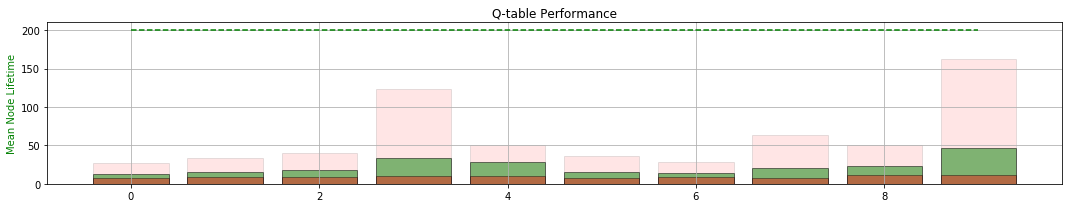

MEMORY COUNTER:  22778
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 5.878	LOSS : 5.357	LOSS : 5.232	LOSS : 5.978	LOSS : 5.864	LOSS : 5.600	LOSS : 5.562	LOSS : 5.678	LOSS : 5.599	LOSS : 5.258	LOSS : 5.375	LOSS : 5.694	LOSS : 5.392	LOSS : 4.903	LOSS : 5.291	LOSS : 5.358	LOSS : 4.873	LOSS : 5.056	LOSS : 5.208	LOSS : 5.119	LOSS : 5.175	LOSS : 4.972	LOSS : 4.748	LOSS : 5.006	LOSS : 5.040	LOSS : 4.961	LOSS : 5.481	LOSS : 4.446	LOSS : 4.493	LOSS : 4.698	
Validating... MEAN TIME:  71.51
LOSS : 5.626	LOSS : 4.350	LOSS : 4.659	LOSS : 5.264	LOSS : 5.346	LOSS : 4.835	LOSS : 4.965	LOSS : 5.083	LOSS : 4.162	LOSS : 4.950	LOSS : 4.882	LOSS : 4.873	LOSS : 5.075	LOSS : 4.898	LOSS : 4.621	LOSS : 4.494	LOSS : 4.568	LOSS : 4.900	LOSS : 4.820	LOSS : 5.400	LOSS : 4.842	LOSS : 4.329	LOSS : 4.456	LOSS : 4.606	LOSS : 4.905	LOSS : 4.178	LOSS : 5.242	LOSS : 4.720	LOSS : 4.802	LOSS : 4.658	
Validating... MEAN TIME:  136.195
LOSS : 4.583	LOSS : 4.7

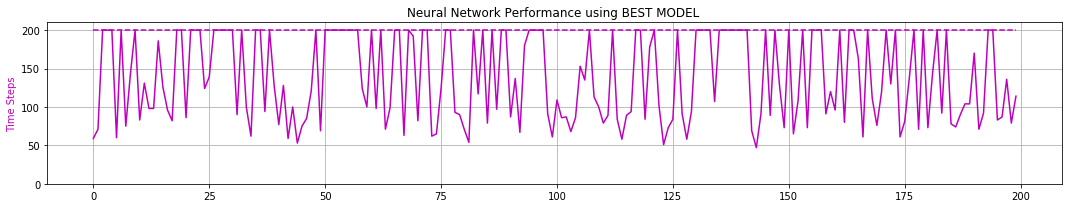

peak memory: 1348.51 MiB, increment: 1035.42 MiB
0 -max- [ 0.050  0.155  0.209  2.757]
0 -min- [-0.212 -1.804 -0.051 -0.079]

1 -max- [ 0.289  1.789  0.060  0.441]
1 -min- [-0.052 -0.245 -0.208 -2.738]

2 -max- [ 0.050  0.234  0.209  2.720]
2 -min- [-0.221 -1.785 -0.050 -0.178]

3 -max- [ 2.397  2.794  0.204  0.787]
3 -min- [-0.082 -0.560 -0.209 -2.505]

4 -max- [ 0.097  0.560  0.209  2.077]
4 -min- [-0.240 -1.219 -0.048 -0.228]

5 -max- [ 0.250  1.804  0.057  0.372]
5 -min- [-0.053 -0.242 -0.209 -2.766]

6 -max- [ 0.049  0.215  0.209  2.710]
6 -min- [-0.217 -1.784 -0.049 -0.213]

7 -max- [ 0.627  1.968  0.137  0.767]
7 -min- [-0.063 -0.402 -0.209 -2.654]

8 -max- [ 0.072  0.558  0.209  2.476]
8 -min- [-0.222 -1.605 -0.050 -0.207]

9 -max- [ 2.393  3.176  0.209  0.828]
9 -min- [-0.126 -0.575 -0.209 -2.237]

Quantization TIME:  0.01 minutes


ITERATION # 1
SMALLEST TIMESTEP in ITERATION 1: 8
REAL TIME TO GENERATE 37219 EXPERIENCES:0:00:01.781889


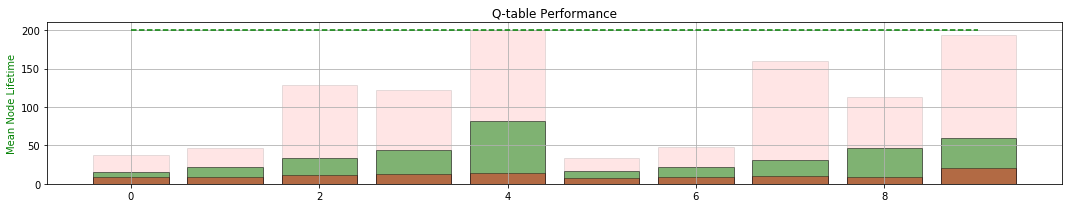

MEMORY COUNTER:  59997
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.534	LOSS : 3.259	LOSS : 3.532	LOSS : 3.556	LOSS : 3.498	LOSS : 3.689	LOSS : 3.468	LOSS : 3.865	LOSS : 3.758	LOSS : 3.886	LOSS : 3.489	LOSS : 4.002	LOSS : 3.590	LOSS : 3.496	LOSS : 3.365	LOSS : 3.875	LOSS : 3.622	LOSS : 3.728	LOSS : 3.627	LOSS : 3.142	LOSS : 3.588	LOSS : 3.213	LOSS : 4.045	LOSS : 3.910	LOSS : 3.599	LOSS : 4.055	LOSS : 3.623	LOSS : 3.525	LOSS : 3.794	LOSS : 4.155	
Validating... MEAN TIME:  110.61
LOSS : 3.883	LOSS : 3.860	LOSS : 4.047	LOSS : 3.680	LOSS : 3.660	LOSS : 3.537	LOSS : 3.831	LOSS : 3.183	LOSS : 3.501	LOSS : 3.648	LOSS : 3.263	LOSS : 3.423	LOSS : 3.611	LOSS : 3.644	LOSS : 3.766	LOSS : 3.711	LOSS : 4.228	LOSS : 3.583	LOSS : 3.583	LOSS : 3.107	LOSS : 3.425	LOSS : 3.799	LOSS : 3.568	LOSS : 3.096	LOSS : 3.701	LOSS : 3.974	LOSS : 4.233	LOSS : 3.543	LOSS : 3.512	LOSS : 4.107	
Validating... MEAN TIME:  172.2
LOSS : 3.378	LOSS : 3.55

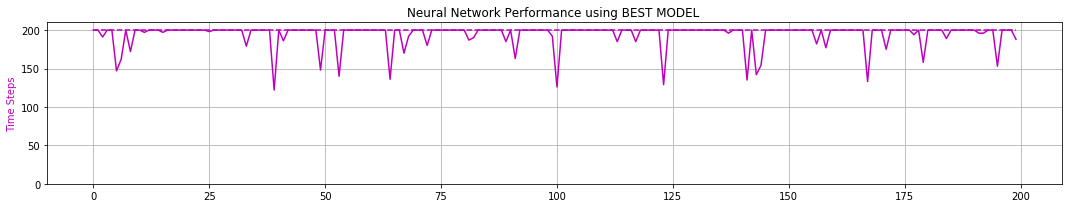

peak memory: 1363.30 MiB, increment: 1036.83 MiB
0 -max- [ 0.063  0.523  0.209  2.746]
0 -min- [-0.223 -1.794 -0.049 -0.349]

1 -max- [ 0.237  1.559  0.046  0.347]
1 -min- [-0.087 -0.570 -0.209 -2.412]

2 -max- [ 0.180  0.949  0.209  2.462]
2 -min- [-0.245 -1.605 -0.050 -0.417]

3 -max- [ 1.828  1.927  0.106  0.431]
3 -min- [-0.151 -0.571 -0.209 -2.205]

4 -max- [ 2.371  2.968  0.209  1.536]
4 -min- [-0.509 -0.975 -0.209 -0.805]

5 -max- [ 0.233  1.797  0.051  0.350]
5 -min- [-0.057 -0.243 -0.209 -2.753]

6 -max- [ 0.084  0.566  0.209  2.504]
6 -min- [-0.223 -1.607 -0.050 -0.357]

7 -max- [ 1.198  1.540  0.092  0.433]
7 -min- [-0.068 -0.549 -0.209 -2.339]

8 -max- [ 0.296  0.941  0.209  2.150]
8 -min- [-0.343 -1.351 -0.059 -0.446]

9 -max- [ 2.378  3.076  0.198  0.469]
9 -min- [-0.229 -0.951 -0.209 -1.731]

Quantization TIME:  0.01 minutes


ITERATION # 2
SMALLEST TIMESTEP in ITERATION 2: 9
REAL TIME TO GENERATE 61166 EXPERIENCES:0:00:02.578694


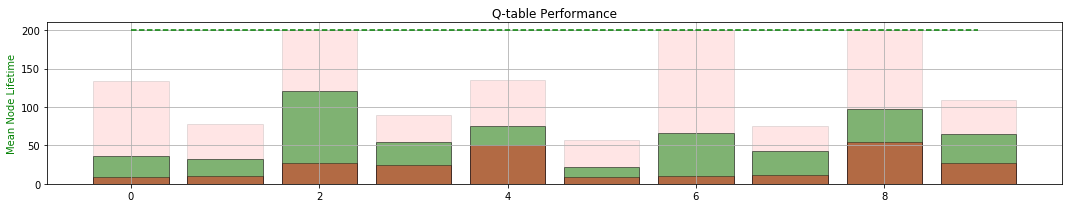

MEMORY COUNTER:  121163
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.028	LOSS : 2.968	LOSS : 2.782	LOSS : 2.578	LOSS : 2.793	LOSS : 2.511	LOSS : 2.674	LOSS : 2.298	LOSS : 2.478	LOSS : 2.203	LOSS : 3.101	LOSS : 3.198	LOSS : 2.691	LOSS : 2.554	LOSS : 2.588	LOSS : 2.720	LOSS : 2.605	LOSS : 2.995	LOSS : 2.744	LOSS : 2.800	LOSS : 2.374	LOSS : 2.698	LOSS : 2.722	LOSS : 2.633	LOSS : 2.268	LOSS : 2.546	LOSS : 2.898	LOSS : 2.585	LOSS : 2.800	LOSS : 2.673	
Validating... MEAN TIME:  199.515
LOSS : 3.014	LOSS : 2.877	LOSS : 2.740	LOSS : 2.651	LOSS : 2.664	LOSS : 2.587	LOSS : 2.823	LOSS : 2.839	LOSS : 2.902	LOSS : 3.147	LOSS : 2.332	LOSS : 2.680	LOSS : 2.772	LOSS : 2.519	LOSS : 2.415	LOSS : 2.590	LOSS : 2.482	LOSS : 2.930	LOSS : 2.257	LOSS : 2.810	LOSS : 2.645	LOSS : 2.434	LOSS : 2.993	LOSS : 2.764	LOSS : 2.651	LOSS : 2.440	LOSS : 2.790	LOSS : 2.544	LOSS : 2.116	LOSS : 2.286	
Validating... MEAN TIME:  199.16
LOSS : 2.607	LOSS : 2

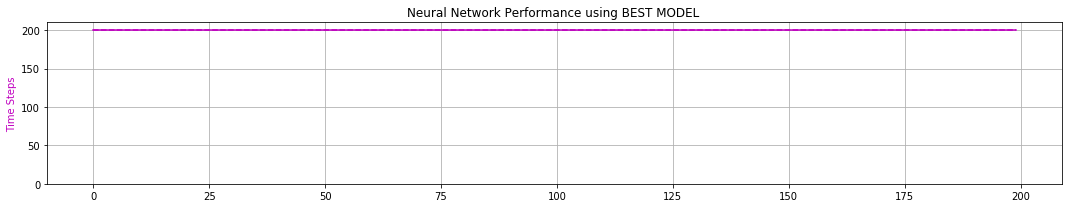

peak memory: 1375.48 MiB, increment: 1002.36 MiB
0 -max- [ 1.613  1.896  0.209  2.536]
0 -min- [-1.032 -1.867 -0.203 -0.685]

1 -max- [ 0.220  1.574  0.049  0.400]
1 -min- [-0.270 -0.948 -0.209 -2.436]

2 -max- [ 2.398  2.408  0.209  1.746]
2 -min- [-2.389 -1.986 -0.209 -0.926]

3 -max- [ 0.221  1.016  0.050  0.400]
3 -min- [-0.399 -1.290 -0.209 -1.572]

4 -max- [ 0.256  0.433  0.056  0.878]
4 -min- [-0.768 -1.337 -0.209 -0.697]

5 -max- [ 0.247  1.595  0.050  0.370]
5 -min- [-0.170 -0.940 -0.209 -2.489]

6 -max- [ 2.392  2.597  0.209  2.387]
6 -min- [-1.969 -2.588 -0.209 -1.053]

7 -max- [ 0.216  1.339  0.049  0.396]
7 -min- [-0.462 -1.279 -0.209 -2.188]

8 -max- [ 2.378  1.485  0.162  1.115]
8 -min- [-0.917 -1.697 -0.209 -0.798]

9 -max- [ 0.198  0.624  0.049  0.405]
9 -min- [-0.435 -1.325 -0.209 -1.278]

Quantization TIME:  0.01 minutes


ITERATION # 3
SMALLEST TIMESTEP in ITERATION 3: 11
REAL TIME TO GENERATE 111399 EXPERIENCES:0:00:03.991527


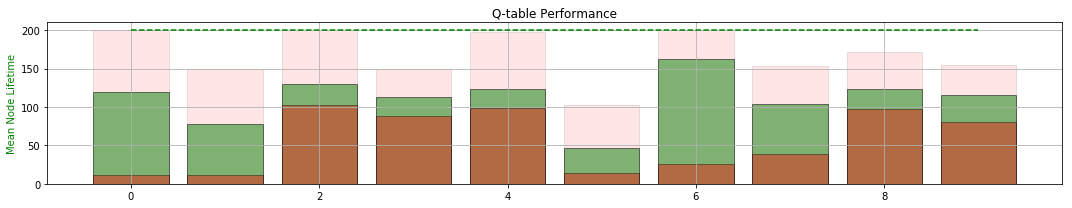

MEMORY COUNTER:  232562
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.982	LOSS : 1.643	LOSS : 1.740	LOSS : 1.983	LOSS : 2.167	LOSS : 2.185	LOSS : 2.233	LOSS : 2.017	LOSS : 1.830	LOSS : 1.808	LOSS : 1.863	LOSS : 1.908	LOSS : 1.852	LOSS : 1.844	LOSS : 1.585	LOSS : 1.782	LOSS : 1.835	LOSS : 1.757	LOSS : 1.898	LOSS : 2.153	LOSS : 2.045	LOSS : 2.165	LOSS : 2.226	LOSS : 1.868	LOSS : 2.235	LOSS : 1.892	LOSS : 1.604	LOSS : 2.194	LOSS : 1.701	LOSS : 1.586	
Validating... MEAN TIME:  200.0
LOSS : 2.186	LOSS : 1.834	LOSS : 1.879	LOSS : 1.777	LOSS : 1.990	LOSS : 2.036	LOSS : 2.370	LOSS : 1.875	LOSS : 1.838	LOSS : 1.604	LOSS : 1.775	LOSS : 1.514	LOSS : 1.886	LOSS : 1.676	LOSS : 1.971	LOSS : 1.450	LOSS : 1.740	LOSS : 1.833	LOSS : 2.244	LOSS : 2.251	LOSS : 2.071	LOSS : 1.784	LOSS : 1.616	LOSS : 2.466	LOSS : 1.867	LOSS : 1.854	LOSS : 1.835	LOSS : 1.617	LOSS : 2.015	LOSS : 2.137	
Validating... MEAN TIME:  200.0
LOSS : 1.901	LOSS : 1.738

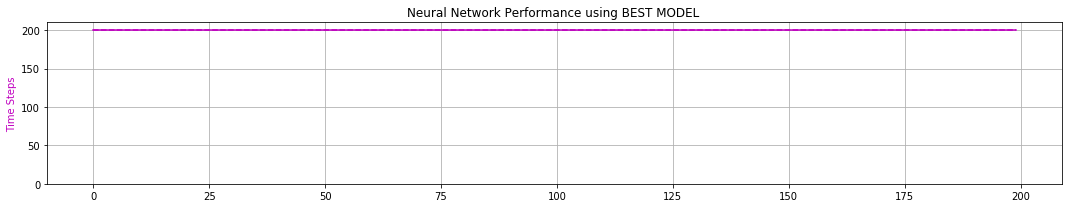

peak memory: 1462.48 MiB, increment: 1017.90 MiB
0 -max- [ 2.399  2.363  0.209  2.248]
0 -min- [-2.397 -2.403 -0.209 -1.006]

1 -max- [ 0.215  0.980  0.050  0.423]
1 -min- [-1.374 -2.017 -0.209 -1.546]

2 -max- [ 0.368  0.614  0.068  0.962]
2 -min- [-2.240 -2.336 -0.209 -0.713]

3 -max- [ 0.184  0.601  0.051  0.426]
3 -min- [-1.537 -1.995 -0.209 -1.119]

4 -max- [ 0.249  0.434  0.050  0.873]
4 -min- [-1.741 -2.218 -0.209 -0.559]

5 -max- [ 0.231  1.382  0.050  0.421]
5 -min- [-1.069 -1.820 -0.209 -2.223]

6 -max- [ 2.186  2.356  0.209  1.938]
6 -min- [-2.394 -2.453 -0.209 -0.972]

7 -max- [ 0.206  0.807  0.048  0.425]
7 -min- [-1.419 -2.025 -0.209 -1.347]

8 -max- [ 0.186  0.432  0.049  0.895]
8 -min- [-1.761 -2.136 -0.209 -0.554]

9 -max- [ 0.194  0.627  0.049  0.426]
9 -min- [-1.456 -1.973 -0.209 -1.078]

Quantization TIME:  0.01 minutes


ITERATION # 4
SMALLEST TIMESTEP in ITERATION 4: 61
REAL TIME TO GENERATE 111519 EXPERIENCES:0:00:03.064191


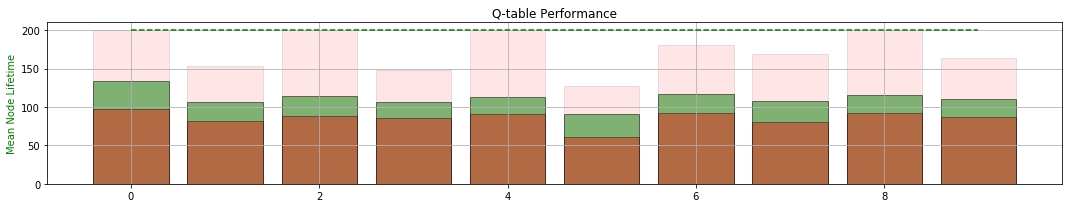

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.255	LOSS : 1.494	LOSS : 1.526	LOSS : 1.473	LOSS : 1.014	LOSS : 1.385	LOSS : 1.329	LOSS : 1.412	LOSS : 1.271	LOSS : 1.315	LOSS : 1.120	LOSS : 1.139	LOSS : 1.947	LOSS : 1.201	LOSS : 1.572	LOSS : 1.737	LOSS : 1.297	LOSS : 1.126	LOSS : 1.445	LOSS : 1.153	LOSS : 1.192	LOSS : 1.470	LOSS : 1.596	LOSS : 0.993	LOSS : 1.288	LOSS : 1.319	LOSS : 1.425	LOSS : 1.464	LOSS : 1.573	LOSS : 1.196	
Validating... MEAN TIME:  199.15
LOSS : 1.431	LOSS : 1.469	LOSS : 1.451	LOSS : 1.572	LOSS : 1.423	LOSS : 1.176	LOSS : 1.391	LOSS : 1.327	LOSS : 1.466	LOSS : 1.482	LOSS : 1.338	LOSS : 1.474	LOSS : 1.641	LOSS : 1.426	LOSS : 1.392	LOSS : 1.452	LOSS : 1.688	LOSS : 1.184	LOSS : 1.420	LOSS : 1.301	LOSS : 1.376	LOSS : 1.532	LOSS : 1.317	LOSS : 1.250	LOSS : 1.510	LOSS : 1.176	LOSS : 1.232	LOSS : 1.322	LOSS : 1.672	LOSS : 1.643	
Validating... MEAN TIME:  193.35
LOSS : 1.272	LOSS : 1.4

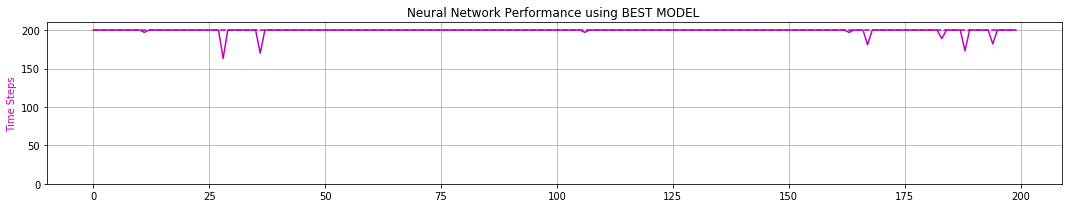

peak memory: 1427.23 MiB, increment: 1018.04 MiB
0 -max- [ 0.545  0.955  0.136  1.430]
0 -min- [-2.393 -2.714 -0.209 -0.774]

1 -max- [ 0.167  0.615  0.050  0.425]
1 -min- [-1.463 -2.167 -0.209 -1.143]

2 -max- [ 0.260  0.438  0.051  0.814]
2 -min- [-1.744 -2.240 -0.209 -0.730]

3 -max- [ 0.230  0.603  0.050  0.425]
3 -min- [-1.470 -2.028 -0.209 -0.958]

4 -max- [ 0.241  0.626  0.056  0.712]
4 -min- [-1.616 -2.183 -0.209 -0.678]

5 -max- [ 0.161  0.832  0.049  0.424]
5 -min- [-1.539 -2.321 -0.209 -1.488]

6 -max- [ 0.228  0.428  0.048  0.938]
6 -min- [-1.807 -2.184 -0.209 -0.701]

7 -max- [ 0.178  0.728  0.049  0.427]
7 -min- [-1.481 -2.047 -0.209 -1.141]

8 -max- [ 0.197  0.558  0.049  0.685]
8 -min- [-1.710 -2.195 -0.209 -0.695]

9 -max- [ 0.209  0.593  0.050  0.425]
9 -min- [-1.534 -2.149 -0.209 -1.005]

Quantization TIME:  0.01 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 34
REAL TIME TO GENERATE 90695 EXPERIENCES:0:00:02.229907


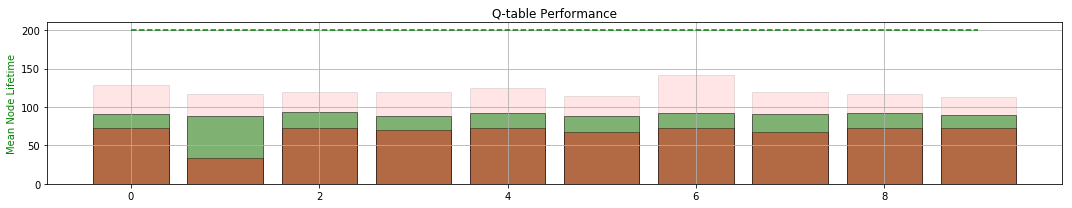

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.529	LOSS : 1.178	LOSS : 1.322	LOSS : 1.323	LOSS : 1.340	LOSS : 1.042	LOSS : 1.242	LOSS : 1.108	LOSS : 0.956	LOSS : 1.149	LOSS : 1.339	LOSS : 1.053	LOSS : 1.244	LOSS : 1.230	LOSS : 1.354	LOSS : 1.138	LOSS : 1.261	LOSS : 1.251	LOSS : 1.154	LOSS : 1.259	LOSS : 1.128	LOSS : 1.425	LOSS : 0.823	LOSS : 1.269	LOSS : 1.294	LOSS : 0.931	LOSS : 1.110	LOSS : 1.101	LOSS : 1.042	LOSS : 1.003	
Validating... MEAN TIME:  134.96
LOSS : 1.228	LOSS : 1.120	LOSS : 1.351	LOSS : 1.189	LOSS : 1.405	LOSS : 1.343	LOSS : 1.133	LOSS : 1.298	LOSS : 1.142	LOSS : 1.385	LOSS : 1.407	LOSS : 1.198	LOSS : 1.070	LOSS : 0.930	LOSS : 1.046	LOSS : 1.350	LOSS : 1.287	LOSS : 1.223	LOSS : 1.352	LOSS : 1.307	LOSS : 1.198	LOSS : 0.932	LOSS : 1.378	LOSS : 0.952	LOSS : 1.082	LOSS : 1.451	LOSS : 1.258	LOSS : 0.927	LOSS : 1.268	LOSS : 1.110	
Validating... MEAN TIME:  138.265
LOSS : 1.159	LOSS : 1.

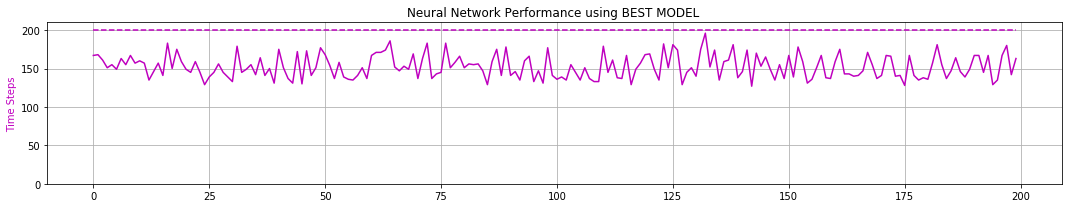

peak memory: 1466.31 MiB, increment: 1017.98 MiB
0 -max- [ 0.147  0.629  0.050  0.723]
0 -min- [-1.471 -2.169 -0.209 -0.745]

1 -max- [ 0.152  0.600  0.051  0.415]
1 -min- [-1.296 -2.025 -0.209 -1.339]

2 -max- [ 0.188  0.629  0.055  0.671]
2 -min- [-1.357 -2.037 -0.209 -0.737]

3 -max- [ 0.161  0.568  0.050  0.414]
3 -min- [-1.263 -2.044 -0.209 -0.900]

4 -max- [ 0.152  0.439  0.049  0.722]
4 -min- [-1.434 -2.148 -0.209 -0.616]

5 -max- [ 0.134  0.621  0.048  0.414]
5 -min- [-1.268 -2.042 -0.209 -1.096]

6 -max- [ 0.137  0.440  0.049  1.218]
6 -min- [-1.802 -2.047 -0.209 -0.618]

7 -max- [ 0.148  0.583  0.049  0.414]
7 -min- [-1.318 -2.018 -0.209 -1.080]

8 -max- [ 0.140  0.577  0.050  0.664]
8 -min- [-1.475 -2.182 -0.209 -0.747]

9 -max- [ 0.167  0.749  0.045  0.414]
9 -min- [-1.262 -2.026 -0.209 -1.142]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 58
REAL TIME TO GENERATE 76333 EXPERIENCES:0:00:01.849009


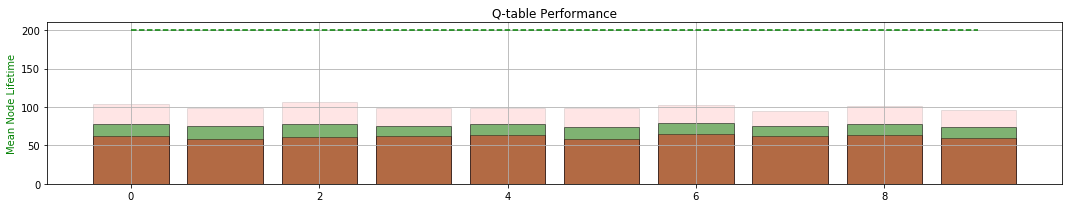

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.180	LOSS : 1.038	LOSS : 1.009	LOSS : 1.098	LOSS : 1.645	LOSS : 1.252	LOSS : 1.195	LOSS : 1.283	LOSS : 1.212	LOSS : 1.417	LOSS : 1.188	LOSS : 1.142	LOSS : 1.232	LOSS : 1.225	LOSS : 0.926	LOSS : 1.111	LOSS : 1.199	LOSS : 1.276	LOSS : 1.345	LOSS : 1.398	LOSS : 0.928	LOSS : 1.081	LOSS : 1.007	LOSS : 1.122	LOSS : 0.964	LOSS : 1.017	LOSS : 1.331	LOSS : 1.455	LOSS : 1.076	LOSS : 1.224	
Validating... MEAN TIME:  134.99
LOSS : 1.285	LOSS : 1.100	LOSS : 1.034	LOSS : 1.079	LOSS : 1.029	LOSS : 1.549	LOSS : 1.321	LOSS : 1.007	LOSS : 0.888	LOSS : 1.229	LOSS : 1.093	LOSS : 1.326	LOSS : 1.163	LOSS : 0.831	LOSS : 1.257	LOSS : 1.196	LOSS : 1.259	LOSS : 1.335	LOSS : 1.406	LOSS : 1.207	LOSS : 1.563	LOSS : 1.151	LOSS : 1.159	LOSS : 1.277	LOSS : 1.220	LOSS : 1.192	LOSS : 0.931	LOSS : 1.206	LOSS : 1.139	LOSS : 1.009	
Validating... MEAN TIME:  137.895
LOSS : 1.297	LOSS : 1.

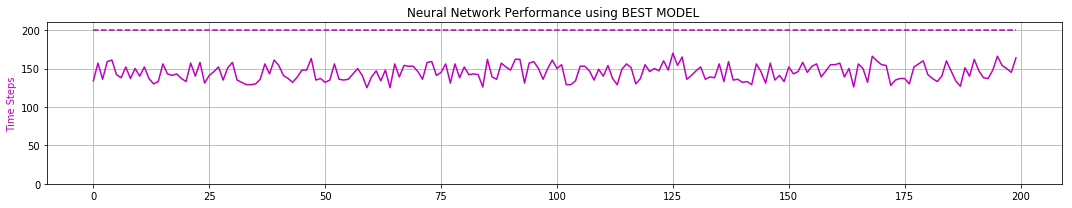

peak memory: 1447.79 MiB, increment: 1053.61 MiB
0 -max- [ 0.160  0.600  0.051  0.762]
0 -min- [-1.542 -2.376 -0.209 -0.750]

1 -max- [ 0.193  0.613  0.050  0.409]
1 -min- [-1.213 -2.226 -0.209 -1.008]

2 -max- [ 0.144  0.556  0.050  0.814]
2 -min- [-1.596 -2.341 -0.209 -0.756]

3 -max- [ 0.139  0.815  0.049  0.408]
3 -min- [-1.190 -2.182 -0.209 -1.165]

4 -max- [ 0.137  0.438  0.048  0.712]
4 -min- [-1.428 -2.357 -0.209 -0.635]

5 -max- [ 0.133  0.791  0.049  0.412]
5 -min- [-1.142 -2.156 -0.209 -1.171]

6 -max- [ 0.150  0.440  0.049  0.645]
6 -min- [-1.457 -2.330 -0.209 -0.634]

7 -max- [ 0.141  0.620  0.050  0.413]
7 -min- [-0.973 -1.863 -0.209 -0.912]

8 -max- [ 0.153  0.439  0.045  0.651]
8 -min- [-1.191 -2.183 -0.209 -0.640]

9 -max- [ 0.130  0.623  0.045  0.409]
9 -min- [-1.177 -2.165 -0.209 -1.081]

Quantization TIME:  0.01 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 45
REAL TIME TO GENERATE 86910 EXPERIENCES:0:00:02.142464


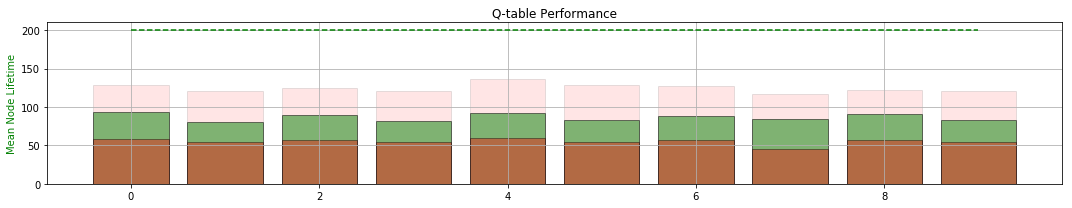

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.999	LOSS : 1.283	LOSS : 1.127	LOSS : 1.307	LOSS : 1.369	LOSS : 1.330	LOSS : 1.383	LOSS : 1.186	LOSS : 1.448	LOSS : 1.071	LOSS : 1.396	LOSS : 1.038	LOSS : 1.153	LOSS : 1.318	LOSS : 1.571	LOSS : 1.193	LOSS : 1.122	LOSS : 1.445	LOSS : 1.252	LOSS : 1.232	LOSS : 1.338	LOSS : 1.522	LOSS : 1.831	LOSS : 1.301	LOSS : 1.111	LOSS : 1.403	LOSS : 1.136	LOSS : 1.026	LOSS : 1.635	LOSS : 1.480	
Validating... MEAN TIME:  153.28
LOSS : 1.038	LOSS : 1.480	LOSS : 1.268	LOSS : 1.422	LOSS : 1.253	LOSS : 1.577	LOSS : 1.135	LOSS : 1.568	LOSS : 1.286	LOSS : 1.123	LOSS : 0.885	LOSS : 1.147	LOSS : 1.308	LOSS : 1.131	LOSS : 1.198	LOSS : 1.068	LOSS : 1.371	LOSS : 0.996	LOSS : 1.215	LOSS : 0.924	LOSS : 0.811	LOSS : 1.360	LOSS : 1.198	LOSS : 1.654	LOSS : 1.291	LOSS : 1.287	LOSS : 1.042	LOSS : 1.114	LOSS : 1.195	LOSS : 1.369	
Validating... MEAN TIME:  124.835
LOSS : 1.046	LOSS : 1.

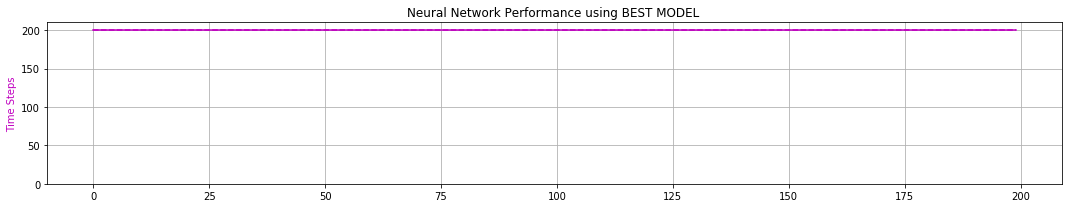

peak memory: 1421.61 MiB, increment: 989.07 MiB
0 -max- [ 0.175  0.611  0.051  0.792]
0 -min- [-2.390 -3.111 -0.209 -0.756]

1 -max- [ 0.141  0.633  0.050  0.404]
1 -min- [-2.393 -2.925 -0.209 -1.063]

2 -max- [ 0.135  0.439  0.049  0.836]
2 -min- [-2.389 -2.949 -0.209 -0.645]

3 -max- [ 0.132  0.789  0.048  0.404]
3 -min- [-2.350 -2.931 -0.209 -1.180]

4 -max- [ 0.127  0.540  0.049  0.791]
4 -min- [-2.386 -3.077 -0.209 -0.747]

5 -max- [ 0.155  0.814  0.049  0.406]
5 -min- [-2.384 -2.952 -0.209 -1.231]

6 -max- [ 0.140  0.439  0.050  0.626]
6 -min- [-2.396 -2.969 -0.209 -0.637]

7 -max- [ 0.155  0.632  0.045  0.408]
7 -min- [-2.389 -2.936 -0.209 -1.143]

8 -max- [ 0.126  0.438  0.045  0.722]
8 -min- [-2.396 -3.113 -0.209 -0.645]

9 -max- [ 0.168  0.625  0.050  0.406]
9 -min- [-2.391 -2.948 -0.209 -0.932]

Quantization TIME:  0.01 minutes


ITERATION # 8
SMALLEST TIMESTEP in ITERATION 8: 77
REAL TIME TO GENERATE 199331 EXPERIENCES:0:00:06.832610


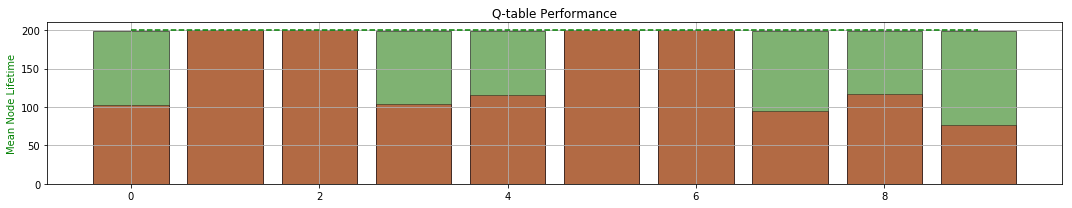

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.663	LOSS : 0.690	LOSS : 0.650	LOSS : 0.624	LOSS : 0.660	LOSS : 0.743	LOSS : 0.993	LOSS : 1.007	LOSS : 0.903	LOSS : 0.537	LOSS : 0.756	LOSS : 0.769	LOSS : 0.656	LOSS : 0.809	LOSS : 0.884	LOSS : 0.703	LOSS : 0.889	LOSS : 0.638	LOSS : 0.452	LOSS : 0.968	LOSS : 0.965	LOSS : 0.499	LOSS : 0.592	LOSS : 0.612	LOSS : 0.739	LOSS : 0.713	LOSS : 0.757	LOSS : 0.485	LOSS : 0.793	LOSS : 0.624	
Validating... MEAN TIME:  200.0
LOSS : 0.839	LOSS : 0.755	LOSS : 0.817	LOSS : 0.592	LOSS : 0.520	LOSS : 0.818	LOSS : 0.596	LOSS : 0.502	LOSS : 0.866	LOSS : 0.766	LOSS : 0.813	LOSS : 0.772	LOSS : 0.876	LOSS : 0.701	LOSS : 0.614	LOSS : 0.640	LOSS : 0.679	LOSS : 0.713	LOSS : 0.823	LOSS : 0.772	LOSS : 0.564	LOSS : 0.606	LOSS : 0.625	LOSS : 0.824	LOSS : 0.783	LOSS : 0.912	LOSS : 0.750	LOSS : 0.697	LOSS : 0.595	LOSS : 0.518	
Validating... MEAN TIME:  196.62
LOSS : 1.013	LOSS : 0.74

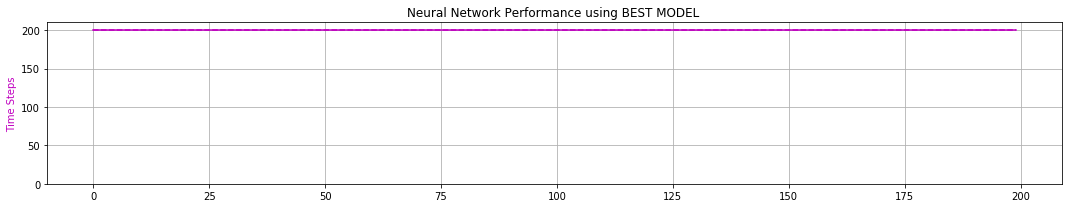

peak memory: 1424.63 MiB, increment: 1017.57 MiB
0 -max- [ 0.401  1.505  0.207  1.040]
0 -min- [-0.706 -1.287 -0.170 -1.028]

1 -max- [ 0.353  1.497  0.206  0.776]
1 -min- [-0.708 -1.170 -0.170 -1.173]

2 -max- [ 0.338  1.350  0.200  1.254]
2 -min- [-0.630 -1.185 -0.166 -1.018]

3 -max- [ 0.331  1.502  0.209  0.763]
3 -min- [-0.743 -1.299 -0.186 -1.184]

4 -max- [ 0.352  1.370  0.203  1.138]
4 -min- [-0.626 -0.990 -0.168 -1.030]

5 -max- [ 0.301  1.500  0.195  0.968]
5 -min- [-0.674 -1.165 -0.168 -1.191]

6 -max- [ 0.359  1.367  0.195  1.007]
6 -min- [-0.677 -1.159 -0.166 -1.024]

7 -max- [ 0.341  1.511  0.209  0.914]
7 -min- [-0.768 -1.308 -0.172 -1.255]

8 -max- [ 0.379  1.549  0.203  1.026]
8 -min- [-0.711 -1.343 -0.175 -1.025]

9 -max- [ 0.363  1.362  0.206  0.948]
9 -min- [-0.793 -1.289 -0.170 -1.078]

Quantization TIME:  0.01 minutes


ITERATION # 9
SMALLEST TIMESTEP in ITERATION 9: 200
REAL TIME TO GENERATE 200000 EXPERIENCES:0:00:06.884546


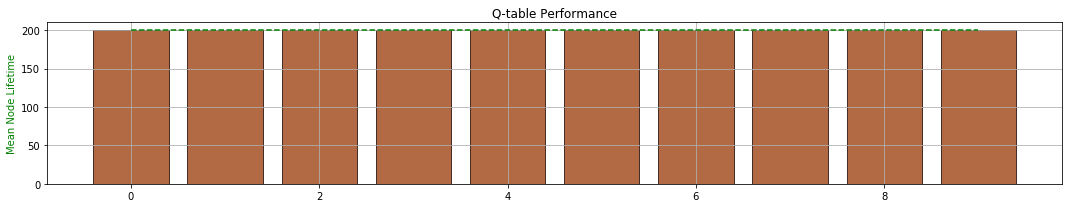

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1745.0
Total Serial Timesteps   :  997350.0
Speed-up                 :  571.55


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   985 SUCCESS 200   9    1745     997350     571.55
